<a href="https://colab.research.google.com/github/Madelinelai/ML/blob/main/2_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

使用 Scikit Learn 預測迴歸問題

1. 迴歸模型
1. 建立驗證集
1. 選擇參數
1. Feature improtance
1. 梯度下降法：複雜的公式如何求解？不使用 scikit learn，自己實作模型

In [ ]:
# 套件安裝 (避免未來 Colab 預設使用新版本 Python 套件造成程式無法執行)
!pip install scikit-learn==0.22.1
!pip install numpy==1.18.2

     |████████████████████████████████| 7.1MB 2.7MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1
     |████████████████████████████████| 20.2MB 42.3MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.18.5
    Uninstalling numpy-1.18.5:
      Successfully uninstalled numpy-1.18.5


In [ ]:
# import 套件
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler

# 固定 random seed，確保每次亂數結果都一樣
np.random.seed(551335114)

In [ ]:
data = fetch_california_housing()
print(data.keys())
print('------------------------------------------------------------')
print("data['feature_names']", data['feature_names'])
print("data['data']: type and shape", type(data['data']), data['data'].shape)
print("data['target']: type and shape", type(data['target']), data['target'].shape)
print('------------------------------------------------------------')
print(data['DESCR'])


dict_keys(['data', 'target', 'feature_names', 'DESCR'])
------------------------------------------------------------
data['feature_names'] ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
data['data']: type and shape <class 'numpy.ndarray'> (20640, 8)
data['target']: type and shape <class 'numpy.ndarray'> (20640,)
------------------------------------------------------------
.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house bl

In [ ]:
# 內建資料沒有測試集(test set)，這邊自己做一個
index = np.arange(len(data['target']))
np.random.shuffle(index)

In [ ]:
n_train = len(index) * 8 // 10
train_feature = data['data'][index[:n_train], :]
train_label = data['target'][index[:n_train]]

test_feature = data['data'][index[n_train:], :]
test_label = data['target'][index[n_train:]]

print('train feature / label shape:', train_feature.shape, train_label.shape)
print('test feature / label shape:', test_feature.shape, test_label.shape)

train feature / label shape: (16512, 8) (16512,)
test feature / label shape: (4128, 8) (4128,)


訓練資料：16512筆

測試資料：4128筆

優化目標：測試資料的均方誤差(mean square error, mse)。

mse = (預測的數值 - 答案)^2 / 筆數

rmse = mse 開根號

模型：Lasso

公式 https://scikit-learn.org/stable/modules/linear_model.html#lasso

使用方法 https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html


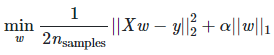

資料越多，regularization 相對越強

In [ ]:
# 1 norm
x = np.array([-1, 1, 2, -4])
print(np.abs(x).sum())
print(np.linalg.norm(x, 1))

8
8.0


In [ ]:
X = np.array([
    [1, 2, 3, 4],
    [5, 6, 7, 8],
    [9, 10, 1, 2]
])
w = np.array([0.1, 0.2, 0.3, 0.5])
y = np.array([0.2, 0.4, -1])
print(np.matmul(X, w))
print(np.power(np.matmul(X, w) - y, 2).sum())
print(np.power(np.linalg.norm(np.matmul(X, w) - y, 2), 2))

[3.4 7.8 4.2]
92.04
92.04000000000002


In [ ]:
# 訓練模型 
model = Lasso()
model.fit(train_feature, train_label)
train_predict = model.predict(train_feature)
print('Train set root mean_squared_error:', np.sqrt(mean_squared_error(train_label, train_predict)))

test_predict = model.predict(test_feature)
print('Test set root mean_squared_error:', np.sqrt(mean_squared_error(test_label, test_predict)))

Train set root mean_squared_error: 0.9789649323468235
Test set root mean_squared_error: 0.9649904748968182


# **交互驗證 Cross validation**

希望對模型做任何調整，都可以在真正使用前先知道怎麼調整比較好。

60 筆資料切三份：A, B, C 各 20 筆

第一次：A + B train, C validate

第二次：A + C train, B validate

第三次：B + C train, A validate



In [ ]:
# 交叉驗證 Cross Validation 選擇參數 - alpha
def cross_validation(feature, label, alpha_range=[0.0001, 0.001, 0.01, 0.1, 1, 10, 100]):
    kf = KFold(n_splits=4, random_state=551335114, shuffle=False)
    best_alpha = 1.0
    best_mse = np.inf
    for alpha in alpha_range:
        subtrain_mse = []
        validation_mse = []
        for subtrain_index, validation_index in kf.split(feature, label):
            subtrain_feature = feature[subtrain_index]
            subtrain_label = label[subtrain_index]
            validation_feature = feature[validation_index]
            validation_label = label[validation_index]
        
            model = Lasso(alpha=alpha)
            model.fit(subtrain_feature, subtrain_label)
            subtrain_predict = model.predict(subtrain_feature)
            subtrain_mse.append(mean_squared_error(subtrain_label, subtrain_predict))

            validation_predict = model.predict(validation_feature)
            validation_mse.append(mean_squared_error(validation_label, validation_predict))
        subtrain_mse = np.mean(np.sqrt(subtrain_mse))
        validation_mse = np.mean(np.sqrt(validation_mse))
        print('ALpha %f Subtrain/Validation root mean_squared_error: %.8f / %.8f' % (alpha, subtrain_mse, validation_mse))
        if validation_mse < best_mse:
            best_mse = validation_mse
            best_alpha = alpha
    return best_alpha

In [ ]:
df = pd.DataFrame(data=train_feature, columns=data['feature_names'])
df['label'] = train_label

df = df.describe()
print(df[df.columns[:5]])
print(df[df.columns[5:]])


             MedInc      HouseAge      AveRooms     AveBedrms    Population
count  16512.000000  16512.000000  16512.000000  16512.000000  16512.000000
mean       3.869625     28.657703      5.421616      1.096600   1424.108224
std        1.898487     12.602713      2.529277      0.492291   1139.332009
min        0.499900      1.000000      0.846154      0.333333      5.000000
25%        2.566775     18.000000      4.434542      1.005638    787.000000
50%        3.533000     29.000000      5.224934      1.048710   1166.000000
75%        4.740575     37.000000      6.042284      1.099490   1728.000000
max       15.000100     52.000000    141.909091     34.066667  35682.000000
           AveOccup      Latitude     Longitude         label
count  16512.000000  16512.000000  16512.000000  16512.000000
mean       3.089272     35.632038   -119.570167      2.067687
std       11.462579      2.137378      2.003319      1.155936
min        0.692308     32.540000   -124.350000      0.149990
25%   

In [ ]:
# linear model 需要 normalize feature，為什麼？
print(train_feature[0])
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
scaler = MinMaxScaler()
feature = scaler.fit_transform(train_feature)
print(feature[0])
best_alpha = cross_validation(feature, train_label, alpha_range=[1e-6, 1e-5, 1e-4, 0.0001, 0.001, 0.01])
print('Best alpha:', best_alpha)
model = Lasso(alpha=best_alpha)
model.fit(feature, train_label)
train_predict = model.predict(feature)
print('Train set root mean_squared_error:', np.sqrt(mean_squared_error(train_label, train_predict)))

feature = scaler.transform(test_feature)
test_predict = model.predict(feature)
print('Test set root mean_squared_error:', np.sqrt(mean_squared_error(test_label, test_predict)))


[ 6.38610000e+00  3.80000000e+01  5.41038961e+00  1.07532468e+00
  1.60000000e+03  2.07792208e+00  3.38900000e+01 -1.18410000e+02]
[0.40593923 0.7254902  0.03235602 0.02199579 0.04470667 0.00111506
 0.1434644  0.59163347]
ALpha 0.000001 Subtrain/Validation root mean_squared_error: 0.72681588 / 0.73445242
ALpha 0.000010 Subtrain/Validation root mean_squared_error: 0.72682580 / 0.73395052


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


ALpha 0.000100 Subtrain/Validation root mean_squared_error: 0.72781491 / 0.73186643
ALpha 0.000100 Subtrain/Validation root mean_squared_error: 0.72781491 / 0.73186643
ALpha 0.001000 Subtrain/Validation root mean_squared_error: 0.73763444 / 0.73835703
ALpha 0.010000 Subtrain/Validation root mean_squared_error: 0.77670100 / 0.77719694
Best alpha: 0.0001
Train set root mean_squared_error: 0.7284674842453469
Test set root mean_squared_error: 0.7127046899863625


# **Feature importance**

哪個特徵最重要？

In [ ]:
# feature importance
print(list(zip(data['feature_names'], model.coef_)))

[('MedInc', 5.968432310206655), ('HouseAge', 0.47920568187340795), ('AveRooms', -9.0438872029081), ('AveBedrms', 14.277463760760602), ('Population', -0.0), ('AveOccup', -3.093367176660278), ('Latitude', -4.085845994189825), ('Longitude', -4.495209112865012)]


# **梯度下降法 Gradient descent**

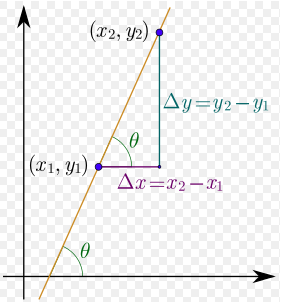

from wiki: https://commons.wikimedia.org/wiki/File:Wiki_slope_in_2d.svg

極值發生在微分 = 0 的地方，那微分不為零的地方？

微分 = 斜率 = dY / dX

走微分的反方向讓函數值變小！

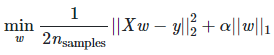

如何求微分？

先把矩陣打開：

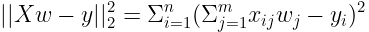

對 wj 微分

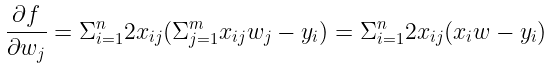

絕對值的微分？

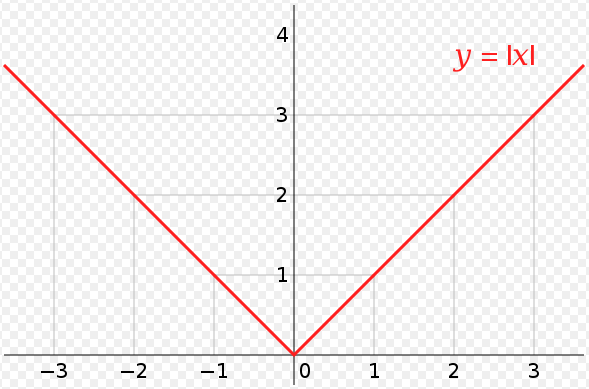

from wiki: https://commons.wikimedia.org/wiki/File:Absolute_value.svg

Gradient descent 在某些條件下是可以保證往函數極小值靠近的

[數學證明](https://machine-learning-notes.gitlab.io/docs/convex_optimization/gradient_descent/)

In [ ]:
w = np.random.random(train_feature.shape[1] + 1) * 2 - 1  # 有一個 bias term
a = 0.0001

def f(X, w, y):
    return np.power(np.linalg.norm(np.matmul(X, w) - y, 2), 2) / X.shape[0] / 2 + a * np.linalg.norm(w, 1)

def gradient(X, w, y):
    g = np.zeros_like(w)
    for i in range(X.shape[0]):
        g += 2 * X[i] * (np.dot(X[i], w) - y[i])
    g = g / X.shape[0] / 2 + a * np.sign(w)
    return g

feature = scaler.fit_transform(train_feature)
print(feature[0])
X = np.hstack((feature, np.ones((feature.shape[0], 1))))
y = train_label
f_pre = np.inf
eps = 1e-4
lr = 1e-2
for i in range(1000):
    fi = f(X, w, y)
    if i % 100 == 0:
        print(fi, np.abs(f_pre - fi))
    if np.abs(f_pre - fi) < eps:
        break
    f_pre = fi
    g = gradient(X, w, y)
    w -= lr * g

print('Weight', w)
print('RMSE', np.sqrt(mean_squared_error(y, np.matmul(X, w))))

[0.40593923 0.7254902  0.03235602 0.02199579 0.04470667 0.00111506
 0.1434644  0.59163347]
1.4097848596196283 inf
0.6629570467702266 0.0010012143073002688
0.62542156659145 0.00016029772882630855
0.6117902021551077 0.00012592936050725978
0.5995983353798406 0.00011850652028932984
0.5880569919726046 0.0001124781928187879
0.577092066712578 0.00010695005997884977
0.5666583180168523 0.00010184179973538043
Weight [ 0.88148426  1.00736319 -0.32326694 -0.1554249   0.61953895  0.64111529
 -0.48377549 -0.42153033  1.65921122]
RMSE 1.0602878594783687


In [ ]:
mw = np.concatenate([model.coef_, [model.intercept_]])
print('Weight from scikit-learn', mw)
print(f(X, mw, y))

Weight from scikit-learn [ 5.96843231  0.47920568 -9.0438872  14.27746376 -0.         -3.09336718
 -4.08584599 -4.49520911  3.8797034 ]
0.269864749265621
